<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Files-on-DBFS/FileStore-Databricks" data-toc-modified-id="Files-on-DBFS/FileStore-Databricks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Files on DBFS/FileStore Databricks</a></span></li><li><span><a href="#Images-Features-Extraction-+-Scaling-&amp;-PCA-Reduction" data-toc-modified-id="Images-Features-Extraction-+-Scaling-&amp;-PCA-Reduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Images Features Extraction + Scaling &amp; PCA Reduction</a></span><ul class="toc-item"><li><span><a href="#Spark-Initialization" data-toc-modified-id="Spark-Initialization-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Spark Initialization</a></span></li><li><span><a href="#Images-loading" data-toc-modified-id="Images-loading-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Images loading</a></span></li><li><span><a href="#Visualization-of-images-and-preprocessing" data-toc-modified-id="Visualization-of-images-and-preprocessing-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Visualization of images and preprocessing</a></span></li><li><span><a href="#Featurization-of-images-with-transfer-learning" data-toc-modified-id="Featurization-of-images-with-transfer-learning-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Featurization of images with transfer learning</a></span></li><li><span><a href="#Scaler" data-toc-modified-id="Scaler-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Scaler</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Export-des-résultats" data-toc-modified-id="Export-des-résultats-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Export des résultats</a></span></li></ul></li></ul></div>

# Files on DBFS/FileStore Databricks

In [ ]:
# Drop files on online stockage server S3 via databricks
display(dbutils.fs.ls("/FileStore/tables"))

In [ ]:
# Unzip files into fruits_360
%sh
unzip /dbfs/FileStore/tables/fruits_360.zip -d /fruits_360

In [ ]:
# Show unzipped files on local server
display(dbutils.fs.ls("file:/fruits_360/fruits-360"))

In [ ]:
# Move them to FileStore in order to be able to use them trough Databricks interface
dbutils.fs.mv("file:/fruits_360/fruits-360", "/FileStore/tables", recurse=True)

In [ ]:
# Example 
display(dbutils.fs.ls("/FileStore/tables/Training/Walnut"))

# Images Features Extraction + Scaling & PCA Reduction
## Spark Initialization

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "4g") \
    .appName('projet-8') \
    .getOrCreate()

22/02/22 17:10:33 WARN Utils: Your hostname, MacBook-Pro-de-Louis.local resolves to a loopback address: 127.0.0.1; using 192.168.0.11 instead (on interface en0)
22/02/22 17:10:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/22 17:10:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

In [3]:
# Importation des librairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import statistics
import os
import random
from os import listdir, walk
from IPython.display import Image
from PIL import Image as Image_PIL
from PIL import ImageFilter
from matplotlib.image import imread
from matplotlib.pyplot import imshow
import cv2
import keras
from skimage.color import rgba2rgb
from skimage import img_as_ubyte

%matplotlib inline

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 50)
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
import pandas as pd
from PIL import Image
import numpy as np
import io

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.sql.functions import col, pandas_udf, PandasUDFType, split, udf

from pyspark.ml.linalg import Vectors, VectorUDT

## Images loading

In [5]:
# Local
path = "/Users/louisrageot/Desktop/OC DS/Projet 8 - Déployez une application sur le cloud/Livrables.nosync/archive/fruits-360_dataset/fruits-360/"
dataset = 'Training/EXTRACT/'

# Cloud
#path = "/FileStore/tables"
#dataset = "/Training"

In [7]:
images = spark.read.format("binaryFile") \
    .option("pathGlobFilter", "*.jpg") \
    .option("recursiveFileLookup", "true") \
    .load(path+dataset)

# Add label
images = images.withColumn("fruit", split(("path"), "/").getItem(12)) # Cloud : getItem(4)

display(images.show())
images.printSchema()

+--------------------+-------------------+------+--------------------+------------------+
|                path|   modificationTime|length|             content|             fruit|
+--------------------+-------------------+------+--------------------+------------------+
|file:/Users/louis...|2021-09-12 19:27:02|  5634|[FF D8 FF E0 00 1...|  Strawberry Wedge|
|file:/Users/louis...|2021-09-12 19:27:02|  4959|[FF D8 FF E0 00 1...|  Strawberry Wedge|
|file:/Users/louis...|2021-09-12 19:26:40|  4729|[FF D8 FF E0 00 1...|     Passion Fruit|
|file:/Users/louis...|2021-09-12 19:26:00|  4496|[FF D8 FF E0 00 1...|          Cherry 1|
|file:/Users/louis...|2021-09-12 19:26:20|  4466|[FF D8 FF E0 00 1...|             Lemon|
|file:/Users/louis...|2021-09-12 19:26:40|  4461|[FF D8 FF E0 00 1...|     Passion Fruit|
|file:/Users/louis...|2021-09-12 19:26:20|  4295|[FF D8 FF E0 00 1...|             Lemon|
|file:/Users/louis...|2021-09-12 19:25:46|  4110|[FF D8 FF E0 00 1...|Apple Granny Smith|
|file:/Use

None

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- fruit: string (nullable = true)



In [8]:
print((images.count(), len(images.columns)))

(14, 5)


## Visualization of images and preprocessing

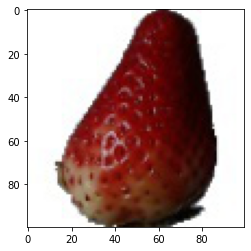

In [71]:
from keras.preprocessing.image import load_img
img_test = "/Users/louisrageot/Desktop/OC DS/Projet 8 - Déployez une application sur le cloud/Livrables.nosync/archive/fruits-360_dataset/fruits-360/Training/Strawberry/255_100.jpg"


# load an image from file
image = load_img(img_test, color_mode="rgb")

plt.imshow(image)

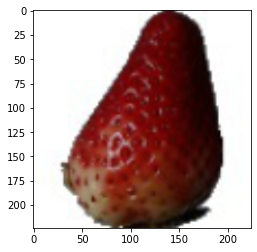

In [72]:
# Resizing to 224,224 for Transfer Learning

image = cv2.resize(np.array(image), (224, 224))

plt.imshow(image)

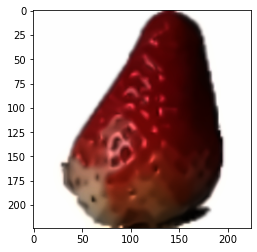

In [75]:
# Noise reduction

image = cv2.fastNlMeansDenoisingColored(
    np.array(image), templateWindowSize=7, searchWindowSize=21, hColor=10)

plt.imshow(image)

## Featurization of images with transfer learning

https://docs.databricks.com/applications/machine-learning/preprocess-data/transfer-learning-tensorflow.html

In [9]:
model = ResNet50(include_top=False)
model.summary()  # verify that the top layer is removed

2022-02-22 17:11:17.579837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-22 17:11:17.580669: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_____________________________________________________________

In [10]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())


def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model

In [11]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)


def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [12]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [13]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
#spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [14]:
# We can now run featurization on our entire Spark DataFrame.

features_df = images.select(col("path"), col(
    "fruit"), featurize_udf("content").alias("features"))
features_df.printSchema()
features_df.show()

# features_df.write.mode("overwrite").parquet("/photos_features")

root
 |-- path: string (nullable = true)
 |-- fruit: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



No supported GPU was found.                                         (0 + 1) / 1]
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to create utility programs
AGX: agxa_device_template.hpp:933:setupCompiler: *** Compiler setup failed.
2022-02-22 17:11:30.049435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-22 17:11:30.052603: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
No supported GPU was found.                                         (0 + 4) / 4]
No supported GPU was found.
No supported GPU was found.
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to creat

+--------------------+------------------+--------------------+
|                path|             fruit|            features|
+--------------------+------------------+--------------------+
|file:/Users/louis...|  Strawberry Wedge|[0.0, 0.0, 0.0, 0...|
|file:/Users/louis...|  Strawberry Wedge|[0.0, 0.0, 0.0, 0...|
|file:/Users/louis...|     Passion Fruit|[0.0, 0.0, 0.0, 0...|
|file:/Users/louis...|          Cherry 1|[0.0, 0.0, 0.0, 0...|
|file:/Users/louis...|             Lemon|[0.0, 0.0, 0.0, 0...|
|file:/Users/louis...|     Passion Fruit|[0.0, 0.0, 0.0, 0...|
|file:/Users/louis...|             Lemon|[0.0, 0.0, 0.0, 0...|
|file:/Users/louis...|Apple Granny Smith|[0.0, 0.0, 0.0, 0...|
|file:/Users/louis...|Apple Granny Smith|[0.0, 0.0, 0.0, 0...|
|file:/Users/louis...|        Grape Blue|[0.0, 0.0, 0.0, 0...|
|file:/Users/louis...|          Cherry 1|[0.0, 0.0, 0.0, 0...|
|file:/Users/louis...|        Grape Blue|[0.0, 0.0, 0.0, 0...|
|file:/Users/louis...|            Banana|[0.0, 0.0, 0.0

In [15]:
features_df.columns

['path', 'fruit', 'features']

In [16]:
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df = features_df.select(
    col("path"), col("fruit"),
    list_to_vector_udf(features_df["features"]).alias("features")
)

## Scaler

In [17]:
#from pyspark.sql.functions import monotonically_increasing_id

#features_df = features_df.select("*").withColumn("id", monotonically_increasing_id())

In [19]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="features_scaled",
                        withStd=True, withMean=True)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(features_df)

# Normalize each feature
features_df_scaled = scalerModel.transform(features_df)

No supported GPU was found.                                         (0 + 7) / 7]
No supported GPU was found.
No supported GPU was found.
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to create utility programs
AGX: agxa_device_template.hpp:933:setupCompiler: *** Compiler setup failed.
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to create utility programs
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to create utility programs
AGX: agxa_device_template.hpp:933:setupCompiler: *** Compiler setup failed.
AGX: agxa_device_template.hpp:933:setup

In [20]:
features_df_scaled.show()

22/02/22 17:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1608.3 KiB
22/02/22 17:12:28 WARN DAGScheduler: Broadcasting large task binary with size 1608.3 KiB
No supported GPU was found.============>                            (2 + 2) / 4]
No supported GPU was found.
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to create utility programs
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to create utility programs
AGX: agxa_device_template.hpp:933:setupCompiler: *** Compiler setup failed.
AGX: agxa_device_template.hpp:933:setupCompiler: *** Compiler setup failed.
2022-02-22 17:12:35.155097: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Opti

+--------------------+------------------+--------------------+--------------------+
|                path|             fruit|            features|     features_scaled|
+--------------------+------------------+--------------------+--------------------+
|file:/Users/louis...|  Strawberry Wedge|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/Users/louis...|  Strawberry Wedge|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/Users/louis...|     Passion Fruit|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/Users/louis...|          Cherry 1|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/Users/louis...|             Lemon|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/Users/louis...|     Passion Fruit|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/Users/louis...|             Lemon|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/Users/louis...|Apple Granny Smith|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/Users/louis...|Apple Granny Smith|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0

## PCA

In [24]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

k = 10

pca = PCA(k=k, inputCol="features_scaled", outputCol="pcaFeatures")
model = pca.fit(features_df_scaled)

result = model.transform(features_df_scaled)

22/02/22 17:18:52 WARN DAGScheduler: Broadcasting large task binary with size 1612.2 KiB
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to create utility programs
AGX: agxa_device_template.hpp:933:setupCompiler: *** Compiler setup failed.
No supported GPU was found.
2022-02-22 17:18:57.263721: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-22 17:18:57.298487: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
22/02/22 17:18:59 WARN DAGScheduler: Broadcasting large task binary with size 1616.3 KiB
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to create utility pr

22/02/22 17:20:29 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/02/22 17:20:30 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to create utility programs
AGX: agxa_device_template.hpp:933:setupCompiler: *** Compiler setup failed.
2022-02-22 17:20:47.353789: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
No supported GPU was found.
2022-02-22 17:20:47.416554: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
22/02/22 17:20:51 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/02/22 17:20:53 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/02/22 17:21:07 WARN DAGScheduler: Broadcasting l

22/02/22 17:22:15 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/02/22 17:22:16 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/02/22 17:22:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/02/22 17:22:28 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/02/22 17:22:51 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/02/22 17:22:52 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/02/22 17:23:14 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/02/22 17:23:14 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/02/22 17:23:26 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/02/22 17:23:26 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/02/22 17:23:34 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/02/22 17:23:35 WARN DAGScheduler: Broadcasting larg

In [25]:
result.show()

22/02/22 17:26:05 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
No supported GPU was found.                                         (0 + 1) / 1]
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to create utility programs
AGX: agxa_device_template.hpp:933:setupCompiler: *** Compiler setup failed.
2022-02-22 17:26:08.596672: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-22 17:26:08.597268: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
22/02/22 17:26:10 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3554:createUtilityP

+--------------------+------------------+--------------------+--------------------+--------------------+
|                path|             fruit|            features|     features_scaled|         pcaFeatures|
+--------------------+------------------+--------------------+--------------------+--------------------+
|file:/Users/louis...|  Strawberry Wedge|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[-21.635252152899...|
|file:/Users/louis...|  Strawberry Wedge|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[-26.000399718868...|
|file:/Users/louis...|     Passion Fruit|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[-33.429905991287...|
|file:/Users/louis...|          Cherry 1|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[-45.087798468849...|
|file:/Users/louis...|             Lemon|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[-22.595209337334...|
|file:/Users/louis...|     Passion Fruit|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[-35.267946625506...|
|file:/Users/louis...|             Lemon|[0.0,0.0,0.0,0

[0.17332571 0.29674035 0.41484642 0.52127224 0.61479798 0.70585412
 0.79230988 0.87307638 0.94006412 1.        ]


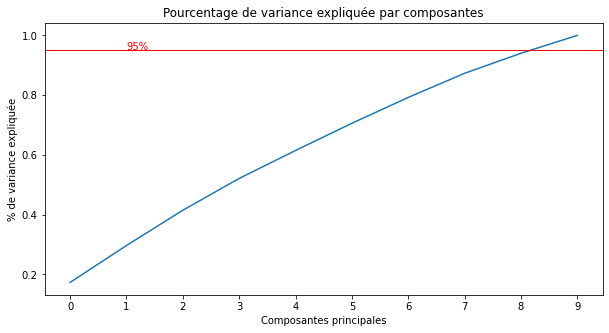

In [115]:
ratios = model.explainedVariance
print(ratios.cumsum())

plt.figure(figsize=(10, 5))
plt.plot(range(len(ratios)), ratios.cumsum())
plt.xticks(range(len(ratios)))
plt.title("Pourcentage de variance expliquée par composantes")
plt.xlabel("Composantes principales")
plt.ylabel("% de variance expliquée")
plt.axhline(0.95, lw=1, c='red')
plt.text(1, 0.95, '95%', c='red')
plt.show()

## Export des résultats

In [30]:
result_pandas = result.toPandas()
result.write.parquet(
    '/Users/louisrageot/Desktop/OC DS/Projet 8 - Déployez une application sur le cloud/Livrables.nosync/results.parquet')

22/02/22 17:33:38 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
No supported GPU was found.                                         (0 + 7) / 7]
No supported GPU was found.
No supported GPU was found.
No supported GPU was found.
No supported GPU was found.
No supported GPU was found.
No supported GPU was found.
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3522:createUtilityProgramIfNeeded_block_invoke: *** Failed to compile Context Save Program
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to create utility programs
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to create utility programs
AGX: agxa_device_template.hpp:3554:createUtilityProgramIfNeeded: *** Failed to create utility pr

In [31]:
result_pandas

,path,fruit,features,features_scaled,pcaFeatures
0,file:/Users/louisrageot/Desktop/OC DS/Projet 8...,Strawberry Wedge,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.294306426029...","[-21.63525215289909, 69.6794680535544, 21.3410..."
1,file:/Users/louisrageot/Desktop/OC DS/Projet 8...,Strawberry Wedge,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.294306426029...","[-26.000399718868877, 252.1703857897934, 45.55..."
2,file:/Users/louisrageot/Desktop/OC DS/Projet 8...,Passion Fruit,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.294306426029...","[-33.42990599128716, -53.087411142709804, -21...."
3,file:/Users/louisrageot/Desktop/OC DS/Projet 8...,Cherry 1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.294306426029...","[-45.087798468849925, -24.3352910338139, -31.9..."
4,file:/Users/louisrageot/Desktop/OC DS/Projet 8...,Lemon,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.294306426029...","[-22.595209337334342, -8.003590800604327, -6.5..."
5,file:/Users/louisrageot/Desktop/OC DS/Projet 8...,Passion Fruit,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.294306426029...","[-35.26794662550657, -44.4339570990333, -32.19..."
6,file:/Users/louisrageot/Desktop/OC DS/Projet 8...,Lemon,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.294306426029...","[-21.01587263327699, -26.503731488079087, -10...."
7,file:/Users/louisrageot/Desktop/OC DS/Projet 8...,Apple Granny Smith,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2869446277618...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.4576176667892...","[-45.69811694700323, 32.90373626666951, -61.05..."
8,file:/Users/louisrageot/Desktop/OC DS/Projet 8...,Apple Granny Smith,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.294306426029...","[-22.080669420196838, -31.754589857274095, -29..."
9,file:/Users/louisrageot/Desktop/OC DS/Projet 8...,Grape Blue,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.294306426029...","[-32.76640197157613, -46.222856792210074, -29...."


In [76]:
result_pandas.to_csv('results_pandas.csv')